In [1]:
import math
import random
import time
import pandas as pd

import gym
import numpy as np
import scipy.linalg

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

<h2>Use CUDA</h2>

In [3]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

<h2>Create Environments</h2>

In [4]:
from multiprocessing_env import SubprocVecEnv

num_envs = 64
env_name = "BikeLQR-v0"

def make_env():
    def _thunk():
        env = gym.make(env_name)
        return env

    return _thunk

envs = [make_env() for i in range(num_envs)]
envs = SubprocVecEnv(envs)

env = gym.make(env_name)

<h2>Neural Network</h2>

In [5]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0., std=0.1)
        nn.init.constant_(m.bias, 0.1)
        

class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size, std=0.0):
        super(ActorCritic, self).__init__()
        
        self.critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
        self.actor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        self.log_std = nn.Parameter(torch.ones(1, num_outputs) * std)
        
        self.apply(init_weights)
        
    def forward(self, x):
        value = self.critic(x)
        mu    = self.actor(x)
        std   = self.log_std.exp().expand_as(mu)
        dist  = Normal(mu, std)
        return dist, value

In [6]:
def plot(frame_idx, rewards):
    clear_output(True)
    #clear_output(False)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('update %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()
    
def test_env(vis=False, init_state=None, nr_steps=int(1e9)):
    if type(init_state) == np.ndarray:
        state = env.reset(init_state=init_state)
    else:
        state = env.reset()
        
    if vis: env.render()
    done = False
    total_reward = 0
    for i in range(nr_steps):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        dist, _ = model(state)
        next_state, reward, done, _ = env.step(dist.sample().cpu().numpy()[0])
        state = next_state
        
        if vis:
            time.sleep(0.1)
            env.render() 
            
        total_reward += reward
        
        if done:
            break
    return total_reward

def get_phi_sequence(state_0):
    state = state_0.copy()
    phi_sequence = [state[0]]
    delta_sequence = []
    v_sequence = [state[2]]
    done = False
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        dist, _ = model(state)
        action = dist.sample().cpu().numpy()[0]
        next_state, reward, done, _ = env.step(action)
        phi_sequence.append(next_state[0])
        delta_sequence.append(action)
        v_sequence.append(next_state[2])
        state = next_state.copy()
    return phi_sequence, delta_sequence, v_sequence

<h2>GAE</h2>

In [7]:
def compute_gae(next_value, rewards, masks, values, gamma=0.99, tau=0.95):
    values = values + [next_value]
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
        gae = delta + gamma * tau * masks[step] * gae
        returns.insert(0, gae + values[step])
    return returns

<h1> Proximal Policy Optimization Algorithm</h1>
<h2><a href="https://arxiv.org/abs/1707.06347">Arxiv</a></h2>

In [8]:
def ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantage):
    batch_size = states.size(0)
    for _ in range(batch_size // mini_batch_size):
        rand_ids = np.random.randint(0, batch_size, mini_batch_size)
        yield states[rand_ids, :], actions[rand_ids, :], log_probs[rand_ids, :], returns[rand_ids, :], advantage[rand_ids, :]
        
        

def ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantages, clip_param=0.2):
    for _ in range(ppo_epochs):
        for state, action, old_log_probs, return_, advantage in ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantages):
            dist, value = model(state)
            entropy = dist.entropy().mean()
            new_log_probs = dist.log_prob(action)

            ratio = (new_log_probs - old_log_probs).exp()
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param) * advantage

            actor_loss  = - torch.min(surr1, surr2).mean()
            critic_loss = (return_ - value).pow(2).mean()

            loss = 0.5 * critic_loss + actor_loss - 0.001 * entropy

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [9]:
num_inputs  = envs.observation_space.shape[0]
num_outputs = envs.action_space.shape[0]

#Hyper params:
hidden_size      = 128
#lr               = 1e-5
lr               = 1e-6
num_steps        = 50
mini_batch_size  = 64
ppo_epochs       = 4
threshold_reward = 10000000

model = ActorCritic(num_inputs, num_outputs, hidden_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [10]:
max_ppo_updates = 4000
ppo_update_idx  = 0
test_rewards = []
highest_test_reward = -np.inf
highest_test_reward = 40


In [11]:
model.load_state_dict(torch.load('saved_networks/ppo_network_IC_uni_pm5_v_0dot5_to_10_uni_eplen100_lr9e-6_brute_3x128_nodes_ver3'))

<All keys matched successfully>

In [12]:
state = envs.reset()
early_stop = False

while ppo_update_idx < max_ppo_updates and not early_stop:

    log_probs = []
    values    = []
    states    = []
    actions   = []
    rewards   = []
    masks     = []
    entropy = 0
    state = envs.reset()

    for _ in range(num_steps):
        state = torch.FloatTensor(state).to(device)
        dist, value = model(state)

        action = dist.sample()
        next_state, reward, done, _ = envs.step(action.cpu().numpy())

        log_prob = dist.log_prob(action)
        entropy += dist.entropy().mean()
        
        log_probs.append(log_prob)
        values.append(value)
        rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(device))
        masks.append(torch.FloatTensor(1 - done).unsqueeze(1).to(device))
        
        states.append(state)
        actions.append(action)
        
        state = next_state
              

    next_state = torch.FloatTensor(next_state).to(device)
    _, next_value = model(next_state)
    returns = compute_gae(next_value, rewards, masks, values)

    returns   = torch.cat(returns).detach()
    log_probs = torch.cat(log_probs).detach()
    values    = torch.cat(values).detach()
    states    = torch.cat(states)
    actions   = torch.cat(actions)
    advantage = returns - values
    
    ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantage)
    
    ppo_update_idx += 1
    if ppo_update_idx % 20 == 0:
        test_reward = np.mean([test_env() for _ in range(100)])
        test_rewards.append(test_reward)
        plot(ppo_update_idx, test_rewards)
        print('Rewards:', test_rewards)
        if test_reward > threshold_reward: early_stop = True
        if test_reward > highest_test_reward:
            torch.save(model.state_dict(), 'saved_networks/best_network')
            highest_test_reward = test_reward

KeyboardInterrupt: 

### Save and load network

In [ ]:
# Save:
#torch.save(model.state_dict(), 'saved_networks/ppo_network')


# Load:
#model.load_state_dict(torch.load('saved_networks/ppo_network'))
#model.load_state_dict(torch.load('saved_networks/ppo_network_IC_uni_pm0dot5_v_0dot5_to_10_uni_3x128_nodes'))

### Get average cumulative reward

In [ ]:
test_reward = np.mean([test_env() for _ in range(200)])
test_reward

### Render

In [ ]:
init_state = np.array([np.deg2rad(-5), 0, 9], dtype=np.float32)
nr_steps_to_render = 30
test_env(vis=True, init_state=init_state, nr_steps=nr_steps_to_render)
env.close()

### Plot sequnce

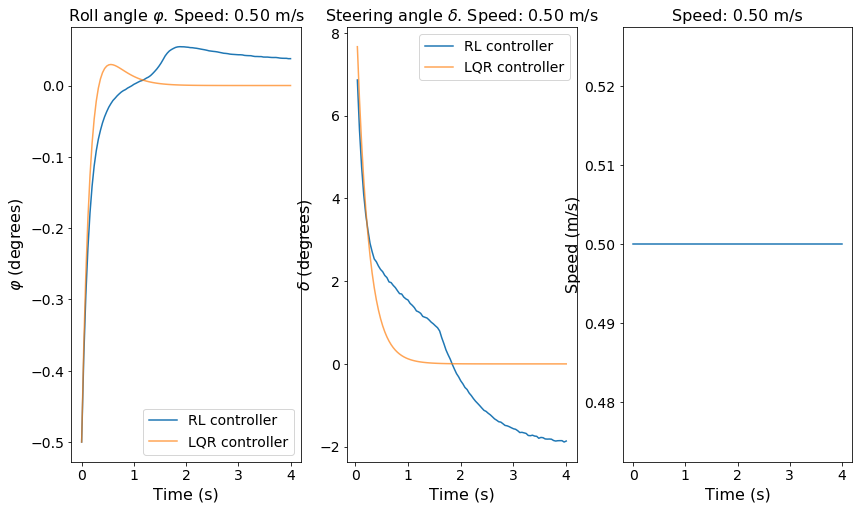

In [15]:
changing_speed = False
init_state = np.array([np.deg2rad(-0.5), 0, 0.5],dtype=np.float32)
state_0 = env.reset(init_state=init_state, changing_speed  = changing_speed)
phi_sequence, delta_sequence, velocity = get_phi_sequence(state_0)

Ts = 0.04
t = np.arange(0, len(phi_sequence)*Ts, Ts)
fig, axes = plt.subplots(1, 3, figsize=(14,8))


axes[0].plot(t, np.rad2deg(phi_sequence), label = "RL controller")
axes[0].set_xlabel('Time (s)', fontsize = 16)
axes[0].set_ylabel(r'$\varphi$ (degrees)', fontsize = 16)
axes[0].set_title(r'Roll angle $\varphi$. Speed: {:.2f} m/s'.format(state_0[2]), fontsize=16)
axes[0].tick_params(axis="x", labelsize=14)
axes[0].tick_params(axis="y", labelsize=14)


axes[1].plot(t[1:], np.rad2deg(delta_sequence), label="RL controller")
axes[1].set_xlabel('Time (s)', fontsize = 16)
axes[1].set_ylabel('$\delta$ (degrees)', fontsize = 16)
axes[1].set_title('Steering angle $\delta$. Speed: {:.2f} m/s'.format(state_0[2]), fontsize = 16);
axes[1].tick_params(axis="x", labelsize=14)
axes[1].tick_params(axis="y", labelsize=14)


axes[2].plot(t, velocity)
axes[2].set_xlabel('Time (s)', fontsize = 16)
axes[2].set_ylabel('Speed (m/s)', fontsize = 16)
axes[2].set_title('Speed: {:.2f} m/s'.format(state_0[2]), fontsize = 16);
axes[2].tick_params(axis="x", labelsize=14)
axes[2].tick_params(axis="y", labelsize=14)

# Plotting the optimal sequences as well (they come from using the K gain from the dlqr algorithm)
from utility_functions import get_optimal_sequence
optimal_phi_sequence, optimal_delta_sequence = get_optimal_sequence(init_state, env, changing_speed = changing_speed)
t_optimal = np.arange(0, len(optimal_phi_sequence)*Ts, Ts)

axes[0].plot(t_optimal, np.rad2deg(optimal_phi_sequence), alpha=0.7, label = "LQR controller")
axes[0].legend(fontsize=14)
axes[1].plot(t_optimal[1:], np.rad2deg(optimal_delta_sequence), alpha=0.7, label="LQR controller")
axes[1].legend(fontsize=14);

<h1>Saving trajectories for GAIL</h1>

In [ ]:
from itertools import count

max_expert_num = 50000
num_steps = 0
expert_traj = []

for i_episode in count():
    state = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        dist, _ = model(state)
        action = dist.sample().cpu().numpy()[0]
        next_state, reward, done, _ = env.step(action)
        state = next_state
        total_reward += reward
        expert_traj.append(np.hstack([state, action]))
        num_steps += 1
    
    print("episode:", i_episode, "reward:", total_reward)
    
    if num_steps >= max_expert_num:
        break
        
expert_traj = np.stack(expert_traj)
print()
print(expert_traj.shape)
print()
np.save("expert_traj.npy", expert_traj)